### Résumé des étapes dans ce notebook 01 :
- Chargement des données (images et légendes).
- Prétraitement des images (redimensionner, normaliser).
- Prétraitement des légendes (nettoyage, tokenisation, padding).
- Association des images et des légendes.
- Division en ensembles d’entraînement et de test.
- Sauvegarde des données.

In [58]:
import os
import numpy as np
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from PIL import Image


In [59]:
# Chemins des données
data_dir = "../datasets/flickr8k/"
images_dir = os.path.join(data_dir, "images/")
captions_file = os.path.join(data_dir, "captions.txt")

# Charger les légendes depuis captions.txt, en ignorant la première ligne
captions_df = pd.read_csv(captions_file, sep=",", header=0, names=["image", "caption"])

# Afficher les premières lignes
print("Aperçu des données brutes :")
print(captions_df.head())
print(f"Nombre total de légendes : {len(captions_df)}")


Aperçu des données brutes :
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
Nombre total de légendes : 40455


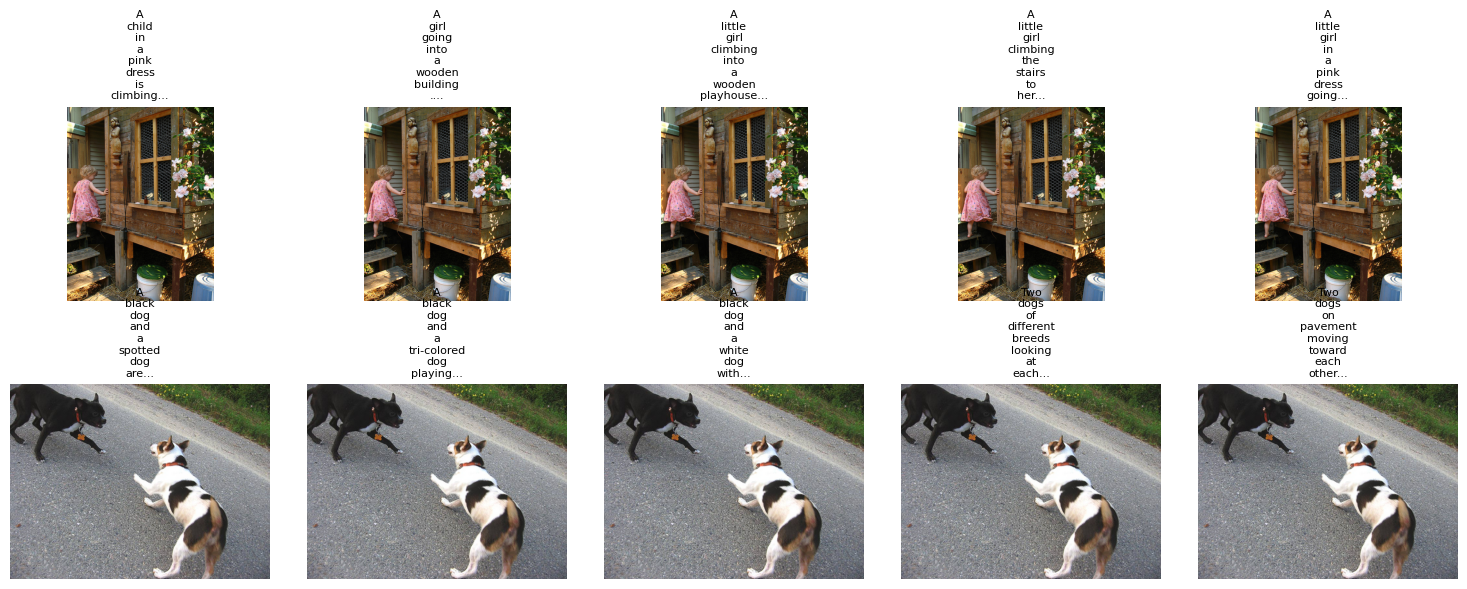

In [ ]:
# Fonction pour afficher les images avec leurs légendes
def display_images_with_captions(df, images_dir, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i >= len(df):
            break
        row = df.iloc[i]
        image_path = os.path.join(images_dir, row["image"])
        
        # Charger et afficher l'image
        try:
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            # Afficher la légende
            ax.set_title("\n".join(row["caption"].split(" ")[:8]) + "...", fontsize=8)
        except Exception as e:
            ax.set_title("Image not found", fontsize=8)
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Afficher les 10 légendes avec leurs images correspondantes : 5 légendes par image
display_images_with_captions(captions_df.head(10), images_dir)


In [61]:
# Fonction pour nettoyer le texte
def clean_caption(caption):
    caption = caption.lower()  # Mettre en minuscule
    caption = re.sub(r"[^a-z0-9 ]", "", caption)  # Retirer les caractères spéciaux
    return caption

# Appliquer le nettoyage sur les légendes
captions_df["cleaned_caption"] = captions_df["caption"].apply(clean_caption)

print("Aperçu des légendes nettoyées :")
print(captions_df[["image", "cleaned_caption"]].head())


Aperçu des légendes nettoyées :
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                     cleaned_caption  
0  a child in a pink dress is climbing up a set o...  
1               a girl going into a wooden building   
2    a little girl climbing into a wooden playhouse   
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


In [62]:
# Initialiser le tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(captions_df["cleaned_caption"])

# Convertir les légendes en séquences
captions_df["caption_sequence"] = tokenizer.texts_to_sequences(captions_df["cleaned_caption"])

# Padding des séquences
max_caption_length = 30
captions_df["padded_sequence"] = pad_sequences(
    captions_df["caption_sequence"], maxlen=max_caption_length, padding="post"
).tolist()

print("Aperçu des séquences de légendes :")
print(captions_df[["image", "padded_sequence"]].head())


Aperçu des séquences de légendes :
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                     padded_sequence  
0  [2, 41, 3, 2, 89, 169, 6, 118, 52, 2, 394, 11,...  
1  [2, 18, 313, 63, 2, 193, 116, 0, 0, 0, 0, 0, 0...  
2  [2, 39, 18, 118, 63, 2, 193, 2430, 0, 0, 0, 0,...  
3  [2, 39, 18, 118, 4, 391, 19, 59, 2430, 0, 0, 0...  
4  [2, 39, 18, 3, 2, 89, 169, 313, 63, 2, 193, 29...  


In [63]:
# Associer chaque image avec ses légendes
data = [
    (os.path.join(images_dir, row["image"]), row["padded_sequence"]) for _, row in captions_df.iterrows()
]

print(f"Nombre total de paires image-légende : {len(data)}")


Nombre total de paires image-légende : 40455


In [64]:
# Diviser les données en train/test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Nombre de paires image-légende dans l'ensemble d'entraînement : {len(train_data)}")
print(f"Nombre de paires image-légende dans l'ensemble de test : {len(test_data)}")


Nombre de paires image-légende dans l'ensemble d'entraînement : 32364
Nombre de paires image-légende dans l'ensemble de test : 8091


In [65]:
# Sauvegarder les données d'entraînement et de test
with open("../datasets/flickr8k/train_data.pkl", "wb") as f:
    pickle.dump(train_data, f)

with open("../datasets/flickr8k/test_data.pkl", "wb") as f:
    pickle.dump(test_data, f)

print("Données prétraitées sauvegardées dans train_data.pkl et test_data.pkl.")


Données prétraitées sauvegardées dans train_data.pkl et test_data.pkl.
